In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

import scipy.stats as sts
import math

from tqdm import tqdm #индикатор прогресса

## Оглавление: <a name=0></a>     
  
* [Bootstrap: методика и области применения](#1)  
    * [Кейс из лекции Karpov.Courses (оценка среднего)](#2)    
    * [Кейс из лекции EXPF (оценка децилей)](#3)  
* [Часто задаваемые вопросы](#4)  
    * [Можно ли использовать bootstrap для нормализации распределения параметра?](#5)  
    * [Можно ли увеличить скорость бутстрапа? (бакетирование)](#6)  
* [Ссылки](#7)

## Bootstrap: методика и области применения <a name=1></a>

Bootstrap помогает оценить наличие статистически значимых различий и построить доверительные интервалы для параметров (метрик), где мы не можем использовать свойста центральной предельной теоремы (ЦПТ), например, для медианы или перцентилей. Bootstrap проще в интерпретации (в отличие от непараметрического теста Манна-Уитни, например) и полезен в ситуациях с небольшими выборками.  

**Области применения:**   
* построение доверительных интервалов для любого сложного параметра распределения без применения математических формул 
* проверка гипотез для любых параметров распределения (например, перцентили/квантили/децили, медианы и тп.) без опоры на его тип (в отличие от классических стат.критериев, где тип распределения влияет на результаты)  
* data science (оценка точности модели)  
* оценка системы сплитования с помощью синтетических А/А-тестов  
  
Чтобы оценить параметр некого неизвестного нам распределения (т.е. получить доверительный интервал) с помощью bootstarap, мы должны быть уверены, что выборка репрезентативна и описывает некую генеральную совокупность.  
  
**Как применить bootstrap:**  
  
<font color='grey'>Шаг 1:</font> многократно взять (например, 1000 раз) из имеющейся выборки бутстрап-подвыборки такого же размера (с возвращениями: то есть в новую подвыборку может несколько раз попасть одно и то же значение)  
<font color='grey'>Шаг 2:</font> рассчитать по каждой такой бутстрап-подвыборке метрику (среднее, перцентили, медиана и тп.)  
<font color='grey'>Шаг 3:</font> сложить все полученные метрики в одну "корзину" и оценить (найти доверительный интервал, рассчитать p-value), чтобы получить общее представление о поведении метрики в генеральной совокупности 
  
**Как проверить гипотезу с помощью bootstrap:**  
  
<font color='grey'>Шаг 1:</font> построить bootstrap-распределение параметра для групп А и В    
<font color='grey'>Шаг 2:</font> вычислить разницу между параметром  
<font color='grey'>Шаг 3:</font> повторить N раз и все результаты из шага 2 сложить в одну корзину  
<font color='grey'>Шаг 4:</font> рассчитать доверительный интервал в получившемся распределении разницы  
<font color='grey'>Шаг 5:</font> проверить, попадает ли 0 в доверительный интервал, если да, то нулевая гипотеза на заданном уровне значимости принимается.   
  
*Как посчитать p-value в bootstrap:*  
в получившемся распределении разнцы считаем количество бут-оценок, выходящие за 0 по обе стороны хвоста при двусторонней проверке и берем по ним минимум. Далее считаем долю таких оценок от всех бут-оценок. Получаем значение p-value.  

### Кейс из лекции Karpov.Courses <a name=2></a>

*Запись лекции [на youtube.](https://youtu.be/-zps6hm0nX8)*  
*Датасет и исходный код лекции можно [скачать по ссылке.](https://yadi.sk/d/-TLefuXoV7Z7FQ?w=1)*
____
  
Датасет представляет собой некие тестовые данные, где есть непрерывная числовая переменная (значение параметра хранится в колонке `value`) и два варианта теста (в колонке `experimentVariant` значение 'Control' – контроль и 'Treatment' – тест).   
  
Познакомимся с данными поближе:

In [2]:
# загрузим датасет
hw_bootstrap = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',', index_col=0)
hw_bootstrap.head()

,value,experimentVariant
1,9.773113,Treatment
2,9.311246,Treatment
3,11.172828,Treatment
4,11.624510,Treatment
5,10.462331,Treatment


In [3]:
# посмотрим на данные и основные параметры
display(hw_bootstrap.info())
display(hw_bootstrap.groupby('experimentVariant')['value'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 1 to 550
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              550 non-null    float64
 1   experimentVariant  550 non-null    object 
dtypes: float64(1), object(1)
memory usage: 12.9+ KB


None

,count,mean,std,min,25%,50%,75%,max
experimentVariant,,,,,,,,
Control,500.0,10.026867,0.979377,6.436541,9.411024,10.018465,10.664879,13.130346
Treatment,50.0,10.367236,1.030919,8.016768,9.953619,10.420193,11.032382,12.191156


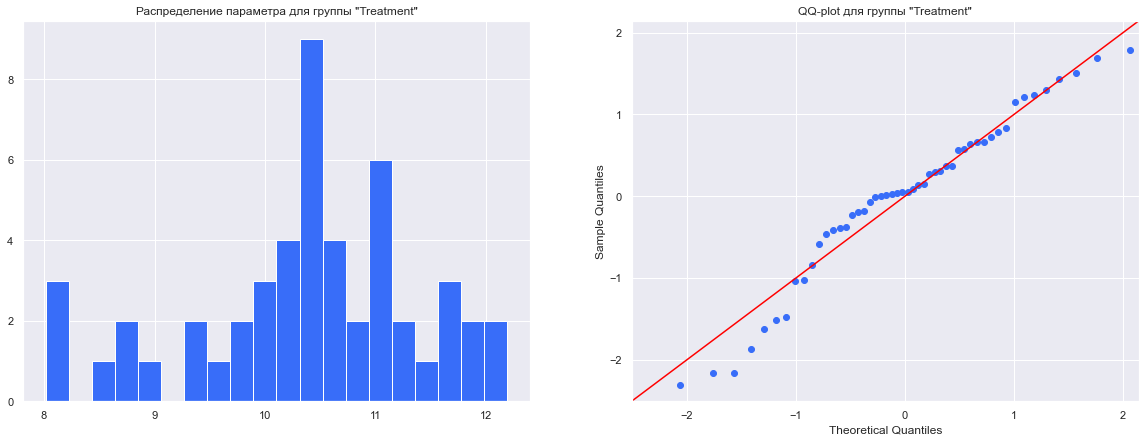

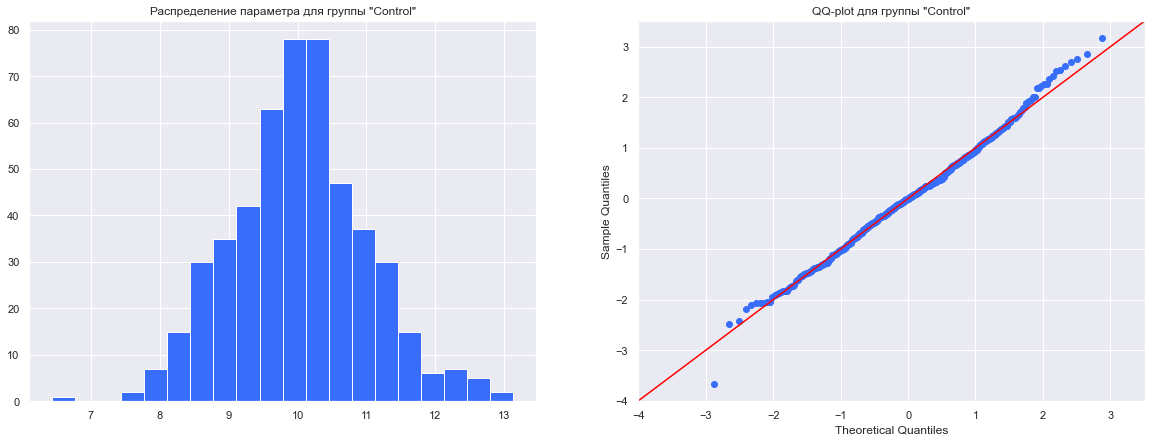

In [4]:
# визуализируем распределение метрики

sns.set(style='darkgrid', palette='rainbow') # общие настройки визуализации

for name in hw_bootstrap['experimentVariant'].unique():
    data = hw_bootstrap.query('experimentVariant == @name')['value']
    
    fig = plt.figure(figsize=(20, 7))
    
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_1.set_title(f'Распределение параметра для группы "{name}"')
    ax_1 = plt.hist(data, bins=20)
    
    ax_2 = fig.add_subplot(1, 2, 2)
    ax_2.set_title(f'QQ-plot для группы "{name}"')
    qqplot(data, sts.norm, fit=True, line="45", ax=ax_2)
    
    plt.show()

Группа теста значительно меньше группы контроля (баланс 10/90) и содержит всего 50 наблюдейний, поэтому мы можем наблюдать значительное количество выбросов на гистограмме и QQ-plot. Но при этом, визуально видно, что распределеение параметра в группе теста скорее всего стремится к нормальному и при росте количества наблюдений распределения группы теста и контроля будут все больше похожи между собой и похожи на нормальное.  
  
*Короткая оговорка:*  
в работе мы сначала продумываем дизайн теста, выбираем методику оценки результатов, а потом только подводим итоги, но так как цель лекции — обучение, далее мы применим несколько статистических критериев (t-критерий и u-критерий Манна_Уитни) и bootstrap. В качестве уровня значимости возьмем значение $alpha = 0.05$.   
  
Средние значения в группах теста и контроля схожи, но все-таки не идентичны (10.367236 и 10.026867 соответственно). Мы хотим оценить значимы ли отличия статистически. Для этого мы можем применить статистические критерии и в зависимости от критерия, будут отличаться нулевые гипотезы, которые мы можем проверить.   

**Зададим уровень значимости:**

In [5]:
alpha = 0.05

**Применим t-критерий Стьюдента:**  
${H_0}$: средние значения двух распределений равны  
${H_1}$: средние значения различаются  

In [6]:
t_stats, p_value_ttest = sts.ttest_ind(hw_bootstrap[hw_bootstrap.experimentVariant == 'Treatment'].value,
                                       hw_bootstrap[hw_bootstrap.experimentVariant == 'Control'].value,
                                       equal_var=False)

print(f'p-value (t-test): {p_value_ttest}')
print(f'p-value < alpha(0.05): {p_value_ttest < alpha}')

p-value (t-test): 0.02920906029906103
p-value < alpha(0.05): True


**Применим u-тест:**    
${H_0}$: распределения параметра в группах теста и контроля одинаковы   
${H_1}$: распределения различаются  
  
Такая формулировка нулевой гипотезы часто встречается и чуть проще для восприятия, но точнее будет говорить о том, что *мы сравниваем значения по каждому из рангов между двумя выборками*. Так как непараметрический тест Манна-Уитни не оценивает непосредственно метрику, это делает его сложным в интерпретации результатов для бизнеса.

In [7]:
u_stats, p_value_utest = sts.mannwhitneyu(hw_bootstrap[hw_bootstrap.experimentVariant == 'Treatment'].value,
                                          hw_bootstrap[hw_bootstrap.experimentVariant == 'Control'].value)

print(f'p-value (u-test): {p_value_utest}')
print(f'p-value < alpha(0.05): {p_value_utest < alpha}')

p-value (u-test): 0.005236419587596797
p-value < alpha(0.05): True


**Применим bootstrap:**  
${H_0}$: средние значения двух распределений равны  
${H_1}$: средние значения различаются  
  
Сначала зададим функцию для рассчета доверительных интервалов и p_value с помощью bootstrap.  
*Функция, представленная ниже взята из лекции, но немного скорректирована:* изменена строка с расчетом разницы средних для бутстрапированных выборок (выдавала ошибку для двух выборок разной размерности), скорректирован код семплирования выборок (чтобы сохранить исходную размерность выборок) и внесены небольшие изменения в код визуализации.

In [8]:
# функция бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = sts.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = sts.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return pd_boot_data, quants, p_value

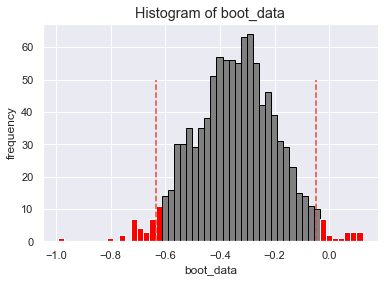

Доверительный интервал (quants):               0
0.025 -0.635295
0.975 -0.049043 

p-value: 0.02512635651706791
p-value < alpha(0.05): True


In [9]:
# применим функцию на наших данных
boot_data, quants, p_value = get_bootstrap(hw_bootstrap.query('experimentVariant == "Control"')['value'], 
                                           hw_bootstrap.query('experimentVariant == "Treatment"')['value'])

print(f'Доверительный интервал (quants): {quants}', '\n')
print(f'p-value: {p_value}')
print(f'p-value < alpha(0.05): {p_value < alpha}')

Подробнее про результаты применения статистических тестов в лекции можно [посмотреть с минуты 13:04](https://youtu.be/-zps6hm0nX8?t=784).     
  
На уровне значимости $\alpha=0.05$ мы получили статистически значимые различия для всех трех проверок, однако, наблюдаемый уровень значимости $p-value$ различен и в случае с более низким порогом $\alpha$ мы получили бы противоречивые результаты. Так же, конечно не корректно применять в одном исследовании все возможные виды критериев, так как разные критерии проверяют разные гипотезы и имеют свои возможности и ограничения, а также дизайн эксперимента в целом зависит от выбранных на старте гипотез и статистического теста.  
  
**Если кратко:**   
— возможная проблема применения t-теста в данном кейсе лежит в размере выборки Treatment (50 наблюдений) — этого количеста наблюдений все-таки недостаточно, чтобы быть уверенными в том, что распределение оценочного параметра стремится к нормальному. Нужно проводить дополнительные исследования данных.   
— результаты u-теста Манна-Уитни сложно интерпретировать с точки зрения бизнеса, так как он оценивает не конкретную метрику, а отличаются ли средние ранги двух групп друг от друга.  
— bootstrap хорошо справляется с выборками небольшого размера или при отсутствии достаточных оснований для применения t-теста (нормальность распределения параметра и равенство дисперсий), сохраняя при этом интерпретируемость теста (мы свободны в выборе оценочного параметра, среднее, медиана, персентили и тд.)  
  
**Итоговое решение по bootstrap:**
С помощью bootstrap для разницы средних между группами контроля и теста (распределение разницы средних визуализировано на гистограмме) мы получили доверительный интервал (с помощью перцентильного метода для заданного уровня значимости) равный `[-0.634752, -0.043704]`, зафиксировали, что ноль в него не входит (косвенная оценка p-value), а также подсчитали вероятность получить наблюдаемое или еще большее отклонение оценки от гипотезы, если гипотеза ${H_0}$ верна: $p-value\approx0.026$  
  
На уровне значимости $\alpha=0.05$ отвергаем ${H_0}$: среднее значение в группе теста на 0.34 больше, чем в группе контроля, $p-value\approx0.026$. Мы сильно уверены в том, что полученный эффект от изменения, а не случайность. Мы ожидаем, что при внедрении изменения мы увеличим метрику в диапазоне от 0.044 до 0.64 пункта.

### Кейс из лекции expf <a name='3'></a>

[Посмотреть описание кейса в лекции на youtube](https://youtu.be/8CMV5cK83ns?t=217)  
**Кейс из фуд-ритейла:**  
Добавили дополнительный блок-витрину "Ваши прошлые покупки" на чекаут (корзина).  
Хотим узнать как изменился средний чек.  
  
Оригинального датасета из лекции в открытом доступе нет, чтобы поэкспериментировать с кодом, я сгенерировала два игрушечных набора данных из двух экспоненциальных распределений.

In [10]:
df_test = pd.read_csv('orders_test.csv', index_col='Unnamed: 0')
df_control = pd.read_csv('orders_control.csv', index_col='Unnamed: 0')

In [11]:
pd.concat([df_test, df_control], ignore_index=True).groupby('group').describe()

value                                                     \
          count         mean          std         min          25%   
group                                                                
control  1100.0  5320.764138  5239.463633  106.060352  1581.955940   
test     1100.0  5607.960308  5137.553826  112.318067  1774.616398   

                                                 
                 50%          75%           max  
group                                            
control  3694.509018  7302.996118  39349.009623  
test     4108.813964  7934.992594  41533.208897

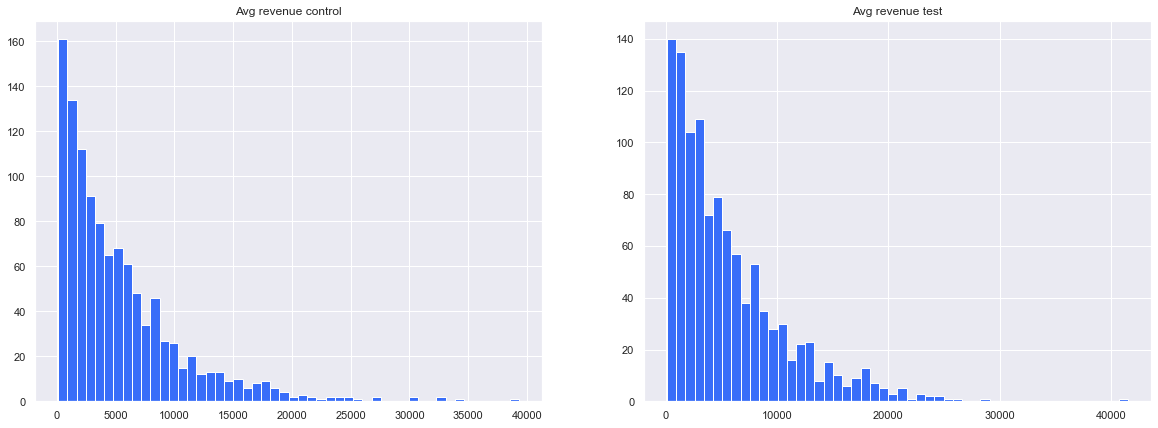

In [12]:
sns.set(style='darkgrid', palette='rainbow')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 7))

ax1.hist(df_control['value'], bins=50)
ax1.set_title('Avg revenue control')

ax2.hist(df_test['value'], bins=50)
ax2.set_title('Avg revenue test')

plt.show()

Распределение средних чеков, которе приводится в лекции в качестве примера, изначально выглядит как экспоненциальное, а среднее в контрольной группе меньше, чем в тестовой. Действительно ли мы наблюдаем закономерность, а не случайный процесс — мы можем убедиться в этом только с помощью применения статистического критерия.  
  
Для решения данного кейса можно было бы применить U-критерий Манна-Уитни и получить ответ на вопрос, отличаются ли распределения двух выборок. Но с точки зрения бизнеса, нам бы _хотелось понимать, где именно произошло значимое изменение_. Чтобы ответить на этот вопрос, мы не будем загонять результаты в критерий, а решим задачу с помощью повторных выборок (bootstrap), сравнивая децили распределений (= каждый 10 процентиль).   
  
**Bootstrap** позволяет сделать оценку любого "сложного" параметра путем нахождения доверительных интервалов для него. Для проверки гипотез — путем вычисления их разницы. В лекции можно [посмотреть демонстрацию](https://youtu.be/8CMV5cK83ns?t=669) принципа работы bootstrap для проверки гипотез.  
  
Применим bootstrap к нашей "игрушечной" смоделированной тестовой выборке, расчитаем среднее для каждой bootstrap-подвыборки и построим распределение оценочного параметра:  

In [13]:
# извлечем 1000 подвыборок с повторами и подсчитаем метрику

boot_test_data = []

for i in range(1000):
    samples_1 = df_test['value'].sample(
        len(df_test['value']), # размер выборки
        replace = True # выборка с повторами
        )#.values
        
    boot_test_data.append(np.mean(samples_1)) # находим мат.ожидание

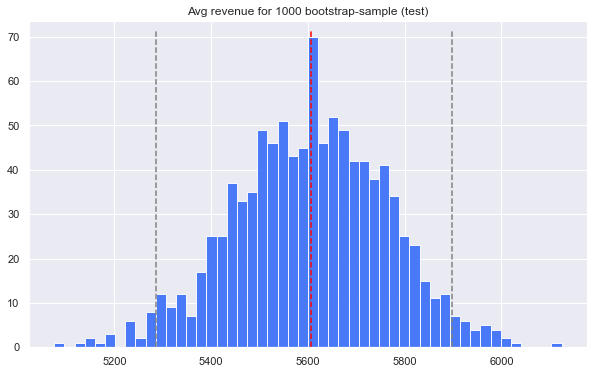

Среднее для 1000 бутстрап-подвыборок: 5605.492206038689
Bias: 2.4681020018143913
Доверительный интервал 95%: [5286.201463775481, 5898.951585708441]


In [14]:
# визуализация результатов:
sns.set(style='darkgrid', palette='rainbow')
fig, ax3 = plt.subplots(figsize=(10, 6))

ax3.hist(boot_test_data, bins=50, alpha=0.9)
ax3.set_title('Avg revenue for 1000 bootstrap-sample (test)')
ax3.axvline(x=np.mean(boot_test_data), ymax=0.97, linestyle='--', color='red')
ax3.axvline(x=float(pd.DataFrame(boot_test_data).quantile(0.025)), ymax=0.97, linestyle='--', color='grey')
ax3.axvline(x=float(pd.DataFrame(boot_test_data).quantile(0.975)), ymax=0.97, linestyle='--', color='grey')

plt.show()
print(f'Среднее для 1000 бутстрап-подвыборок: {np.mean(boot_test_data)}')
print(f'Bias: {np.mean(df_test["value"] - np.mean(boot_test_data))}')
print('Доверительный интервал 95%:', 
      f'[{float(pd.DataFrame(boot_test_data).quantile(0.025))},',
      f'{float(pd.DataFrame(boot_test_data).quantile(0.975))}]')

На графике распределения оценчного параметра (в нашем случае — среднего значения) синими пунктирными линиями обозначены границы 95% доверительного интервала, а красной — математическое ожидание для получившегося распределения.
  
**Bias** — это разница между средним изначального распределения (группа теста) и средним, которое мы получили после bootstrap. Чем ниже bias, тем лучше, тем точнее мы можем получить оценку по выбранной нами метрике. В нашем случае мы получили небольшой bias, то есть оценщик достаточно точный.  
  
Дополнительно посмотрим, как картина будет выглядеть для другой метрики — медианы, чтобы лучше разобраться, каким может быть bias в разных ситуациях:

In [35]:
boot_median_data = []

for i in range(500):
    samples_1 = df_test['value'].sample(
        len(df_test['value']), # размер выборки
        replace = True # выборка с повторами
        )
        
    boot_median_data.append(np.median(samples_1))

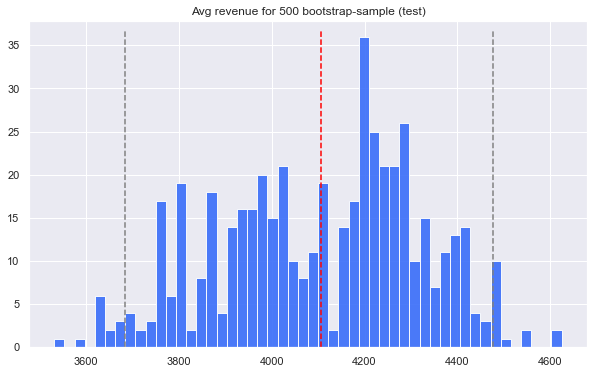

Медиана для 500 бутстрап-подвыборок: 4143.921168339908
Bias: -35.10720460837365
Доверительный интервал 95%: [3684.2041193846076, 4477.120778177069]


In [36]:
# визуализация результатов:
sns.set(style='darkgrid', palette='rainbow')
fig, ax3 = plt.subplots(figsize=(10, 6))

ax3.hist(boot_median_data, bins=50, alpha=0.9)
ax3.set_title('Avg revenue for 500 bootstrap-sample (test)')
ax3.axvline(x=np.mean(boot_median_data), ymax=0.97, linestyle='--', color='red')
ax3.axvline(x=float(pd.DataFrame(boot_median_data).quantile(0.025)), ymax=0.97, linestyle='--', color='grey')
ax3.axvline(x=float(pd.DataFrame(boot_median_data).quantile(0.975)), ymax=0.97, linestyle='--', color='grey')

plt.show()
print(f'Медиана для 500 бутстрап-подвыборок: {np.median(boot_median_data)}')
print(f'Bias: {np.median(df_test["value"] - np.median(boot_median_data))}')
print('Доверительный интервал 95%:', 
      f'[{float(pd.DataFrame(boot_median_data).quantile(0.025))},',
      f'{float(pd.DataFrame(boot_median_data).quantile(0.975))}]')

Я умышленно взяла меньшее количество бутстрап-подвыборок, чтобы получить более наглядный bies. [В видео-лекции приведен пример](https://youtu.be/8CMV5cK83ns?t=931) с еще большей разницей. В моем случае, увеличение количества подвыборок приведет к уменьшению bias, но так бывает не всегда — это одна из проблем сложных оценочных параметров (высокий bias).  
  
Если наблюдается высокий bias, то необходимо либо провести подгонку оценщика к исходной выборке, либо использовать smoothed bootstrap (модификация bootstrap, добавляет шума в бутстапированную выборку, за счет чего немного сглаживается распределение).  
  
**Вернемся к задаче:**  
Разделим выборки на 10 равных частей (децили/каждая 10 квантиль): так мы сможем понять насколько сильно у нас отличаются, например, мелкие корзины друг от друга (так как мы анализируем локальный "небольшой" участок распределения, а не полностью распределения между собой).  
Для каждого дециля рассчитываем доверительный интервал с помощью bootstrap.  
Сравним результаты.  
  
*В видео-лекции от EXPF показано, как сделать [рассчеты для среднего с помощью R](https://youtu.be/8CMV5cK83ns?t=1242)*. Это аналогичный код, который используется выше в кейсе Karpov.Courses. Но для задачи с перцентилями он не подходит, поэтому чуть скорректируем код под нашу задачу:  

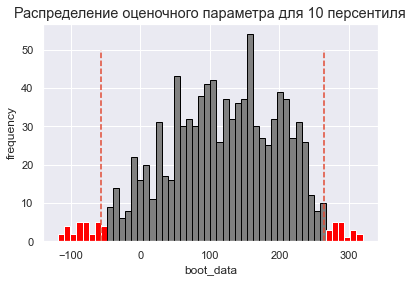

Средняя разница параметра: 0    118.182688
dtype: float64
Доверительный интервал: (-56.60124916176377, 263.7055161211834)
p-value: 0.16149150568513282 



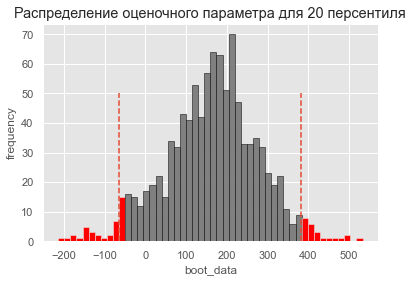

Средняя разница параметра: 0    162.987318
dtype: float64
Доверительный интервал: (-64.04603670623072, 381.01420627215464)
p-value: 0.15068450544842563 



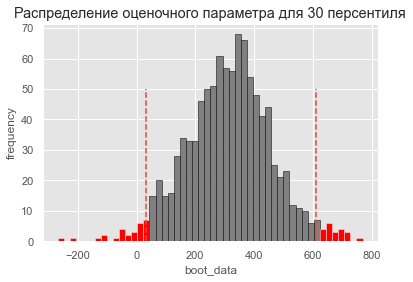

Средняя разница параметра: 0    313.286384
dtype: float64
Доверительный интервал: (33.61085348200884, 609.2789526901344)
p-value: 0.02985153940694454 



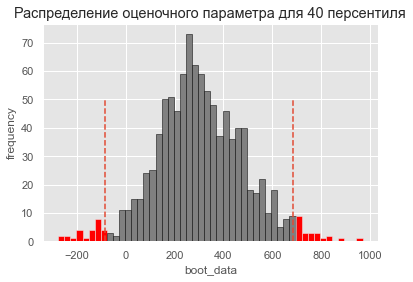

Средняя разница параметра: 0    303.000804
dtype: float64
Доверительный интервал: (-86.20545354012755, 685.0308990383583)
p-value: 0.09523757792687823 



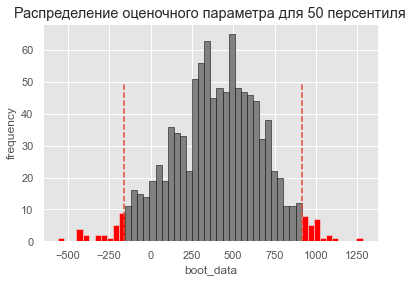

Средняя разница параметра: 0    398.069578
dtype: float64
Доверительный интервал: (-157.8062824583852, 913.1302959244551)
p-value: 0.14912206339325174 



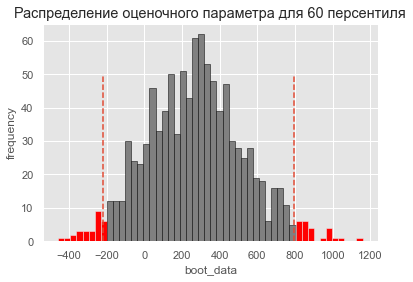

Средняя разница параметра: 0    270.663109
dtype: float64
Доверительный интервал: (-218.09942333087236, 795.8305895596233)
p-value: 0.2900019640112288 



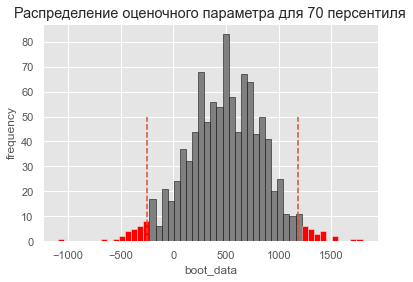

Средняя разница параметра: 0    493.918611
dtype: float64
Доверительный интервал: (-249.9543739327, 1186.943748056119)
p-value: 0.17582612452543944 



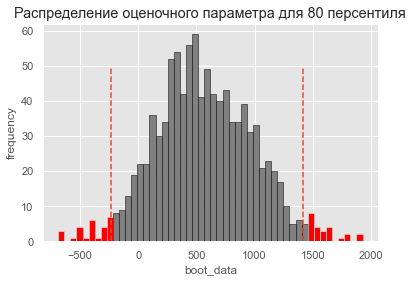

Средняя разница параметра: 0    564.919776
dtype: float64
Доверительный интервал: (-229.094464174615, 1414.7366129803886)
p-value: 0.1783869264543846 



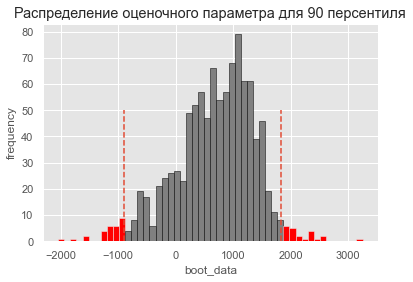

Средняя разница параметра: 0    679.380514
dtype: float64
Доверительный интервал: (-900.4679121488381, 1827.6834631293812)
p-value: 0.32731673737322897 



In [17]:
res = pd.DataFrame(columns=['q_group', 'p_value', 'mean_difference', 'ci_left', 'ci_right'])

for q in range(10, 100, 10):
    boot_data = []
    percentile_sample_1 =[]
    percentile_sample_2 =[]
    bootstrap_conf_level = 1 - alpha
    for i in range(1000):
        sample_1 = df_test['value'].sample(
            len(df_test['value']),
            replace = True
        ) 
        
        sample_2 = df_control['value'].sample(
            len(df_control['value']),
            replace = True
        )
        
        boot_data.append(np.percentile(sample_1, q=q) - np.percentile(sample_2, q=q))
        percentile_sample_1.append(np.percentile(sample_1, q=q))
        percentile_sample_2.append(np.percentile(sample_2, q=q))
        
    pd_boot_data = pd.DataFrame(boot_data)
    mean_difference = np.mean(boot_data)
    
    # доверительный интервал
    left_quant = float(pd_boot_data.quantile((1 - bootstrap_conf_level)/2))
    right_quant = float(pd_boot_data.quantile(1 - (1 - bootstrap_conf_level) / 2))
    
    # p-value
    p_1 = sts.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = sts.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= left_quant or bar.get_x() >= right_quant:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines([left_quant, right_quant],ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title(f'Распределение оценочного параметра для {q} персентиля')
    plt.show()
    
    res = res.append({'q_group': q, 
                      'p_value': p_value, 
                      'mean_difference': mean_difference,
                      'ci_left': left_quant, 
                      'ci_right': right_quant},
                     ignore_index=True
                    )
    
    print(f'Средняя разница параметра: {pd_boot_data.mean()}')
    print(f'Доверительный интервал: {left_quant, right_quant}')
    print(f'p-value: {p_value}', '\n')

In [18]:
res

,q_group,p_value,mean_difference,ci_left,ci_right
0,10.0,0.161492,118.182688,-56.601249,263.705516
1,20.0,0.150685,162.987318,-64.046037,381.014206
2,30.0,0.029852,313.286384,33.610853,609.278953
3,40.0,0.095238,303.000804,-86.205454,685.030899
4,50.0,0.149122,398.069578,-157.806282,913.130296
5,60.0,0.290002,270.663109,-218.099423,795.830590
6,70.0,0.175826,493.918611,-249.954374,1186.943748
7,80.0,0.178387,564.919776,-229.094464,1414.736613
8,90.0,0.327317,679.380514,-900.467912,1827.683463


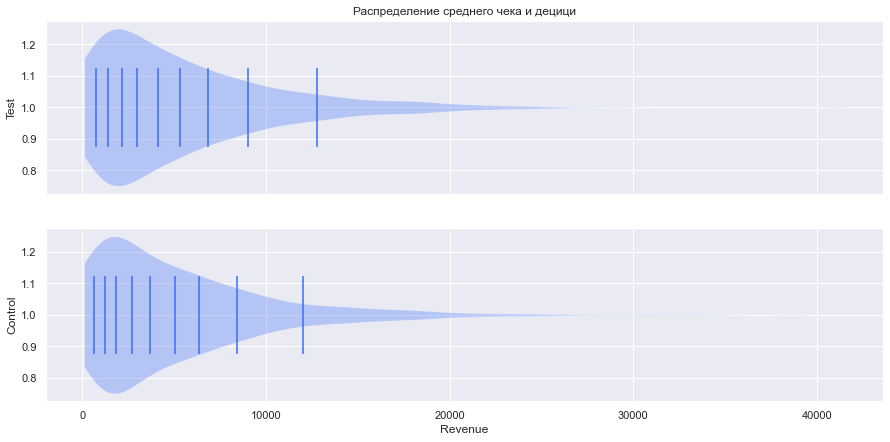

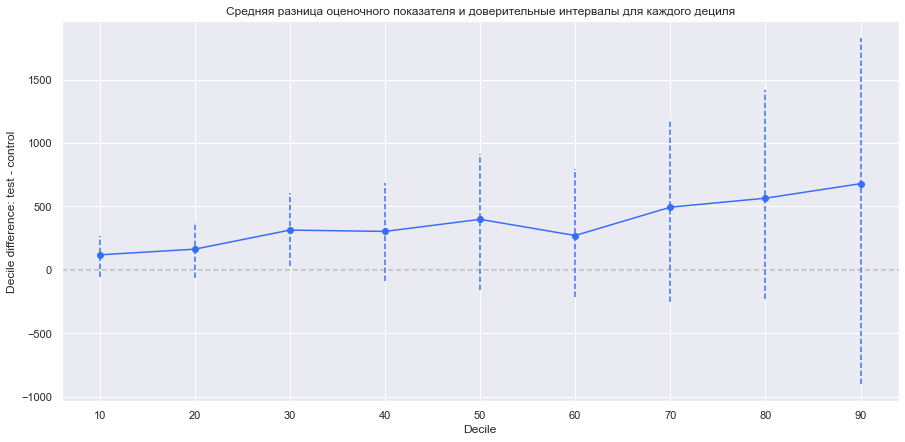

In [19]:
sns.set(style='darkgrid', palette='rainbow')
fig, (ax4, ax5) = plt.subplots(2,1, sharex=True, figsize=(15, 7))
quantiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]

ax4.violinplot(df_test['value'], vert=False, quantiles=quantiles, points=1100, showextrema=False)
ax4.set_title('Распределение среднего чека и децици')
ax4.set_ylabel('Test')
ax5.violinplot(df_control['value'], vert=False, quantiles=quantiles, points=1100, showextrema=False)
ax5.set_ylabel('Control')
ax5.set_xlabel('Revenue')
plt.show()

fig, ax6 = plt.subplots(figsize=(15, 7))
ax6.plot(res['q_group'], res['mean_difference'], '-o')
ax6.vlines(res['q_group'], ymin=res['ci_left'], ymax=res['ci_right'], linestyle='--')
ax6.axhline(y=0.0, color='grey', linestyle='--', alpha=0.5)
ax6.set_title('Средняя разница оценочного показателя и доверительные интервалы для каждого дециля')
ax6.set_xlabel('Decile')
ax6.set_ylabel('Decile difference: test - control')

plt.show()

На последнем графике визуализирована разница между показателями группы теста и и контроля, полученные с помощью bootstrap: для каждого дециля мы отметили среднее значение разницы (точка) и вертикальными пунктирными линиями обозначили доверительный интервал. 
  
Если в доверительный интервал попадает 0 (ДИ пересекается с серой пунктирной линией), то мы не можем говорить о наличии разницы между децилями распределений.  
  
**Итоговое решение:**  
В нашем примере мы наблюдаем, что доверительный интервал для 3 дециля не включает 0 на заданном уровне значимости ($\alpha = 0.05$), соответственно на этом локальном участке мы можем говорить о наличии различий и отвергнуть нулевую гипотезу. У нас есть основания полагать, что наше изменение на чек-ауте повлияло на средний чек для мелких корзин, при этом крупные корзины не изменились. Мы можем ожидать повышение среднего чека для 30 персентиля на 45.616637 - 589.349475 единиц.  
  
**Оговорка:** в лекции не углублялись в тему множественных сравнений, но в случае со сравнениями децилей необходимо было бы учесть поправку. Мы можем взять поправку Бонферонни ($\frac{\alpha}{m}$), где $m$ — количество попарных сравнений. В Netflix [в одном из кейсов](https://netflixtechblog.com/streaming-video-experimentation-at-netflix-visualizing-practical-and-statistical-significance-7117420f4e9a) используют Бонферонни, но скорректированный ("...Bonferroni Correction — using an estimate of the number of independent values of the delta-quantile function"). *Если скорректировать выводы в нашем кейсе с учетом поправки на множественное сравнение*, то мы не сможем говорить о наличии различий и отвергнуть ${H_0}$.

## Часто задаваемые вопросы <a name=4></a>

**1) Можно ли использовать bootstrap для нормализации распределения параметра?**<a name=5></a>  
  
*Bootstrap* — это полноценный оценщик и его *нельзя применять в качестве нормализации распределения* метрики, чтобы потом к нему применить статистический критерий и cделать выводы на основе полученной статистики и p-value.  
  
Для применения параметрических критериев (например, t-критерий Стьюдента) требуется соблюдать предположение о независимости выборок, а bootstrap протеворечит этому в самой сути — bootstrap-подвыборки формируются с повторами, то есть наблюдение может встретиться много-много раз в одном и том же распределении.  

**2) Можно ли увеличить скорость бутстрапа?** <a name=6></a>   
  
*Можно с помощью бакетирования.*  
Этот вопрос возникает в условиях, когда в выборке большое количество наблюдений и процесс формирования bootstrap-подвыборок сильно замедляется. Проблема в том, что для bootstrap-подвыборок нужно задавать размер такой же, как и у изначальной выборки, так как изменение статистики будет зависеть от размера выборки. Если мы хотим аппроксимировать эту изменчивость, нам нужно сохранять размерность повторных выборок. Но в ситуациях, где у нас большое количество наблюдений (~1 млн и более), начинаются проблемs со скоростью вычислений.  
  
В этом случае мы можем сначала разложить нашу выборку по бакетам (этот метод позволяет сохранить характеристики исходного распределения и нормализовать его) и уже их "скормить" в bootstrap.  
  
*Бакетирование:*  
Шаг 1: рандомно присваиваем номер группы от B1 до Bn, где Bn — оптимальное количество групп, которое мы усредним (например, =500, в лекции в качестве оптимума предлагается — 1000), одно наблюдение может попасть только в одну такую группу  
Шаг 2: усредняем параметры в каждой группе  
Шаг 3: из усредненных значений получаем распределение близкое к нормальному

In [20]:
# сгенерируем dataset
sample_data = pd.DataFrame(
    data={
        'values': np.concatenate((np.random.exponential(0.5, 100000), np.random.exponential(0.6, 100000)),
                                 axis=None
                                ),
        'group': np.repeat(np.array(['A','B']), [100000,100000]),
        'backet': np.tile(np.arange(1,501), 400)
    }
)

sample_data.head()

,values,group,backet
0,0.329094,A,1
1,1.972552,A,2
2,0.305161,A,3
3,0.066671,A,4
4,0.439974,A,5


In [21]:
# сгруппируем по бакетам и вариантам
# найдем среднее и стандартное отклонение
backet_sample_data = (
    sample_data
    .groupby(['group', 'backet'], as_index=False)
    .agg({'values': [np.mean, np.std]})
)

backet_sample_data.head()

group backet    values          
                    mean       std
0     A      1  0.512831  0.497199
1     A      2  0.524037  0.507400
2     A      3  0.494012  0.433264
3     A      4  0.473589  0.505556
4     A      5  0.550677  0.484890

Среднее для бакетированных данных и полных в группе А равны: True
Среднее для бакетированных данных и полных в группе B равны: True


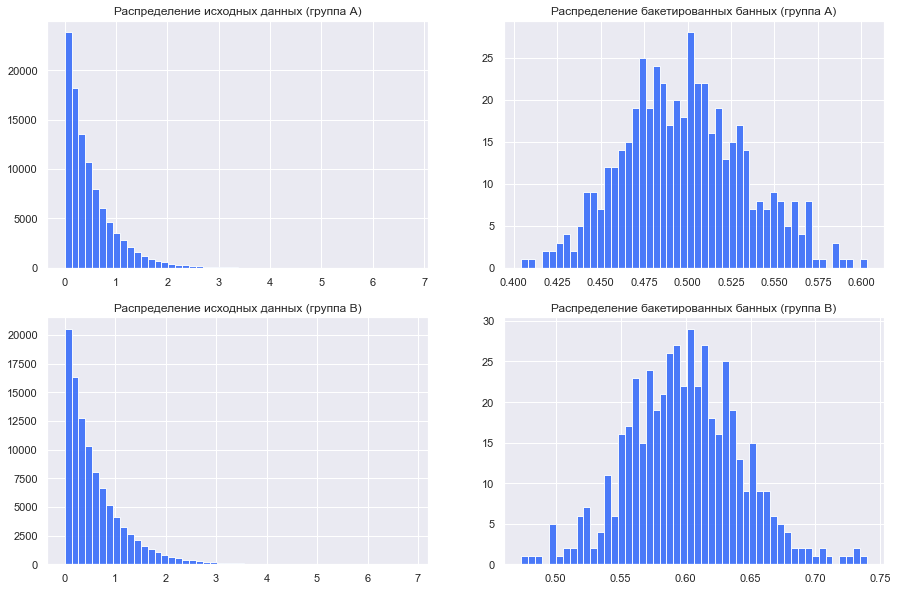

In [30]:
# сравним среднее для бакетированных данных и полных (возьмем среднее до 8 знака после запятой)
print('Среднее для бакетированных данных и полных в группе А равны:', 
      round(sample_data[sample_data['group'] == 'A']['values'].mean(), 8) == 
      round(backet_sample_data[backet_sample_data['group'] == 'A']['values']['mean'].mean(), 8)
     )

print('Среднее для бакетированных данных и полных в группе B равны:', 
      round(sample_data[sample_data['group'] == 'B']['values'].mean(), 8) == 
      round(backet_sample_data[backet_sample_data['group'] == 'B']['values']['mean'].mean(), 8)
     ) 

# визуализируем распределения до и после бакетирования
sns.set(style='darkgrid', palette='rainbow')
fig, ax6 = plt.subplots(2, 2, figsize=(15, 10))

ax6[0][0].hist(sample_data[sample_data['group'] == 'A']['values'], bins=50, alpha=0.9)
ax6[0][0].set_title('Распределение исходных данных (группа А)')

ax6[0][1].hist(backet_sample_data[backet_sample_data['group'] == 'A']['values']['mean'], bins=50, alpha=0.9)
ax6[0][1].set_title('Распределение бакетированных банных (группа А)')

ax6[1][0].hist(sample_data[sample_data['group'] == 'B']['values'], bins=50, alpha=0.9)
ax6[1][0].set_title('Распределение исходных данных (группа B)')

ax6[1][1].hist(backet_sample_data[backet_sample_data['group'] == 'B']['values']['mean'], bins=50, alpha=0.9)
ax6[1][1].set_title('Распределение бакетированных банных (группа B)')

plt.show()

При таком подходе сохраняется условие о независимости наблюдений, благодаря равномерному распределению по бакетам (в отличие от бутстрапа), а также сохраняется информация о метрике в исходной выборке при ее меньшем размере (полезно для автоматизированных вычислений): дисперсия и сама метрика  
$$\frac{s^2}{N}\approx\frac{s^2_b}{B}$$

Бакетирование полезно, когда наблюдений достаточно много (например, 1 млн и больше). Применяя bootstrap к бакетированным данным, мы можем значительно ускорить расчеты (в симуляции при 1 млн строк без бакетов = 40 сек, а с бакетами = 0,27 сек)   

____
## Ссылки <a name=7></a>

[Ccылка на лекцию](https://youtu.be/-zps6hm0nX8) от Karpov.Courses и [материалы лекции](https://yadi.sk/d/-TLefuXoV7Z7FQ?w=1)   
[Cсылка на лекцию EXPF](https://youtu.be/8CMV5cK83ns) и [на презентацию и код на R из лекции](https://drive.google.com/file/d/1nSC1KDpVvbxWIg31shTtkNWdZu4SPVt3/view)  

Рекомендованные ссылки из лекции от EXPF:  
* [Про bootstrap](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf)   
* Bootstrap. Хорошее [объяснение в этой лекции](https://www.coursera.org/learn/inferential-statistics-intro/lecture/u3k1n/bootstrapping)  
* [Перцентильный bootstrap](https://garstats.wordpress.com/2016/05/27/the-percentile-bootstrap/)  
* [Пакет R для квантильного сравнения с помощью bootstrap](https://github.com/GRousselet/rogme)  
  (тут включена коррекция на множественные сравнения и коррекция bias’а для квантилей) 
* [Проверка АА-теста с помощью бутстрэпа](https://habr.com/ru/company/hh/blog/321386/)      

___
Ковальчук Юлия  
[Linkedin](https://www.linkedin.com/in/julia-kovalchuk/) | [Telegram](https://t.me/data_lama)